In [1]:
import pandas as pd
import numpy as np

from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [2]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

path = '../input/poemsdataset'

poems = get_text_files(path, folders=['forms', 'topics'])
print(len(poems), "poems found")

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

20657 poems found


In [3]:
hymns = get_text_files(path+'/forms', folders = ['hymn'])
print(len(hymns),"hymns found")

hymns = L(o.open().read() for o in hymns)

100 hymns found


In [4]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i, list):
            rt.extend(flatten(i))
        else:
            rt.append(i)
    return rt

In [5]:
all_hymns = flatten(hymns)

In [6]:
class TransformersTokenizer(Transform):
    def __init__(self, token):
        self.tokenizer = tokenizer

    def encodes(self, x):
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))

    def decodes(self, x):
        return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [7]:
split = [range_of(70), range(100)]
tls = TfmdLists(all_hymns, TransformersTokenizer(tokenizer),
                splits=split, dl_type=LMDataLoader)


show_at(tls.train, 0)

Token indices sequence length is longer than the specified maximum sequence length for this model (1986 > 1024). Running this sequence through the model will result in indexing errors


Vicisti, Galilæe
I have lived long enough, having seen one thing, that love hath an end;
Goddess and maiden and queen, be near me now and befriend.
Thou art more than the day or the morrow, the seasons that laugh or that weep;
For these give joy and sorrow; but thou, Proserpina, sleep.
Sweet is the treading of wine, and sweet the feet of the dove;
But a goodlier gift is thine than foam of the grapes or love.
Yea, is not even Apollo, with hair and harpstring of gold,
A bitter God to follow, a beautiful God to behold?
I am sick of singing; the bays burn deep and chafe: I am fain
To rest a little from praise and grievous pleasure and pain.
For the Gods we know not of, who give us our daily breath,
We know they are cruel as love or life, and lovely as death.
O Gods dethroned and deceased, cast forth, wiped out in a day!
From your wrath is the world released, redeemed from your chains, men say.
New Gods are crowned in the city; their flowers have broken your rods;
They are merciful, clothed

In [8]:
bs, sl = 4, 256
dls = tls.dataloaders(bs=bs, seq_len=sl)

dls.show_batch(max_n=2)

,text,text_
0,"The groves were God's first temples. Ere man learned\nTo hew the shaft, and lay the architrave,\nAnd spread the roof above them,---ere he framed\nThe lofty vault, to gather and roll back\nThe sound of anthems; in the darkling wood,\nAmidst the cool and silence, he knelt down,\nAnd offered to the Mightiest solemn thanks\nAnd supplication. For his simple heart\nMight not resist the sacred influences,\nWhich, from the stilly twilight of the place,\nAnd from the gray old trunks that high in heaven\nMingled their mossy boughs, and from the sound\nOf the invisible breath that swayed at once\nAll their green tops, stole over him, and bowed\nHis spirit with the thought of boundless power\nAnd inaccessible majesty. Ah, why\nShould we, in the world's riper years, neglect\nGod's ancient sanctuaries, and adore\nOnly among the crowd, and under roofs,\nThat our frail hands have raised? Let me, at least,\nHere, in the shadow of this aged wood,\nOffer one hymn---thrice happy, if it find\nAcceptance","groves were God's first temples. Ere man learned\nTo hew the shaft, and lay the architrave,\nAnd spread the roof above them,---ere he framed\nThe lofty vault, to gather and roll back\nThe sound of anthems; in the darkling wood,\nAmidst the cool and silence, he knelt down,\nAnd offered to the Mightiest solemn thanks\nAnd supplication. For his simple heart\nMight not resist the sacred influences,\nWhich, from the stilly twilight of the place,\nAnd from the gray old trunks that high in heaven\nMingled their mossy boughs, and from the sound\nOf the invisible breath that swayed at once\nAll their green tops, stole over him, and bowed\nHis spirit with the thought of boundless power\nAnd inaccessible majesty. Ah, why\nShould we, in the world's riper years, neglect\nGod's ancient sanctuaries, and adore\nOnly among the crowd, and under roofs,\nThat our frail hands have raised? Let me, at least,\nHere, in the shadow of this aged wood,\nOffer one hymn---thrice happy, if it find\nAcceptance in"
1,"loud waves are dumb\nListening to my sweet pipings.\nThe wind in the reeds and the rushes,\nThe bees on the bells of thyme,\nThe birds on the myrtle-bushes,\nThe cicale above in the lime,\nAnd the lizards below in the grass,\nWere as silent as ever old Tmolus was,\nListening to my sweet pipings.\nLiquid Peneus was flowing,\nAnd all dark Temple lay\nIn Pelion's shadow, outgrowing\nThe light of the dying day,\nSpeeded by my sweet pipings.\nThe Sileni and Sylvans and fauns,\nAnd the Nymphs of the woods and wave\nTo the edge of the moist river-lawns,\nAnd the brink of the dewy caves,\nAnd all that did then attend and follow,\nWere silent with love,--as you now, Apollo,\nWith envy of my sweet pipings.\nI sang of the dancing stars,\nI sang of the dedal earth,\nAnd of heaven, and the Giant wars,\nAnd love, and death, and birth.\nAnd then I changed my pipings,--\nSinging how","waves are dumb\nListening to my sweet pipings.\nThe wind in the reeds and the rushes,\nThe bees on the bells of thyme,\nThe birds on the myrtle-bushes,\nThe cicale above in the lime,\nAnd the lizards below in the grass,\nWere as silent as ever old Tmolus was,\nListening to my sweet pipings.\nLiquid Peneus was flowing,\nAnd all dark Temple lay\nIn Pelion's shadow, outgrowing\nThe light of the dying day,\nSpeeded by my sweet pipings.\nThe Sileni and Sylvans and fauns,\nAnd the Nymphs of the woods and wave\nTo the edge of the moist river-lawns,\nAnd the brink of the dewy caves,\nAnd all that did then attend and follow,\nWere silent with love,--as you now, Apollo,\nWith envy of my sweet pipings.\nI sang of the dancing stars,\nI sang of the dedal earth,\nAnd of heaven, and the Giant wars,\nAnd love, and death, and birth.\nAnd then I changed my pipings,--\nSinging how down"


In [9]:
class DropOutput(Callback):
    def after_pred(self):
        self.learn.pred = self.pred[0]

In [10]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [11]:
learn.validate()

(#2) [4.4478888511657715,85.44636535644531]

SuggestedLRs(valley=0.0002754228771664202)

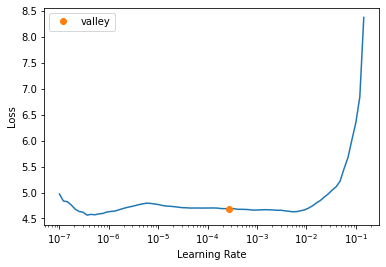

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.560205,4.179752,65.349670,00:23


In [14]:
prompt = 'Waves on the ocean'
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 5])

In [15]:
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
Waves on the ocean floor.
I'll take you to the shore,
And I'll bring you back to shore
To the sea-floor, where you'll find me.


You'll see my face, and your eyes will see
My face. You'll hear my voice


In [16]:
prompt = "Among the trees"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
Among the trees of the earth,
And the stars of heaven, and the moon's stars;
The stars, the sun's rays, are cast down
From the heavens, from the sky, to the sea.
But, behold, I say unto you, there is not a man


In [17]:
prompt = "The mist that lies beneath the sky"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=150, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
The mist that lies beneath the sky, and the stars that are in the midst of it,
And the clouds that surround it;
But the sun and moon, the moon and stars
That are not in their midst, nor are they seen
By the naked eye, or by the blind eye
Of men who have seen them.
They are the shadows of the night; they are their shadows
On the earth, on the sea; and they lie in wait
For the day when they shall rise again, when the world shall come
From the dead to the living.


"And now, behold, I say unto thee, thou art the Son of God."
I say to thee: "Thy kingdom come
